In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
import seaborn as sns
from tqdm import tqdm
from fuzzywuzzy import fuzz

train_example_paths = glob.glob('data/train/*.json')
test_example_paths = glob.glob('data/test/*.json')

train_example_names = [fn.split('.')[0] for fn in os.listdir('data/train')]
test_example_names = [fn.split('.')[0] for fn in os.listdir('data/test')]

metadata = pd.read_csv('data/train.csv')
metadata_train = metadata.loc[metadata.Id.isin(train_example_names)]
metadata_test = metadata.loc[metadata.Id.isin(test_example_names)]

In [ ]:
metadata_train.Id == '2f392438-e215-4169-bebf-21ac4ff253e1'

In [2]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def get_doc_id(doc_path):
    return os.path.split(train_example_names[0])[-1].split('.')[0]

def load_train_example(i: int):
    doc_path = train_example_paths[i]
    with open(doc_path) as f:
        data = json.load(f)
    return {'doc': data, 'meta': metadata.loc[metadata.Id == get_doc_id(doc_path)]}

def load_train_example_by_name(name):
    doc_path = os.path.join('data/train', name + '.json')
    with open(doc_path) as f:
        data = json.load(f)
    return data

def indices(lst, element):
    result = []
    for i, txt in enumerate(lst):
        if fuzz.ratio(txt, element) > 80:
            result.append(i)
    return result

def delete_file(filename):
    if os.path.exists(filename):
        os.remove(filename)

## Split Data

In [3]:
import random

docIdx = metadata_train.Id.values.copy()
random.seed(42)
random.shuffle(docIdx)

train_ratio = 0.8
n_train = int(len(docIdx) * train_ratio)
n_val = len(docIdx) - n_train

train_idx = docIdx[:n_train]
val_idx = docIdx[n_train:]

print(f'train size: {len(train_idx)}')
print(f'val size: {len(val_idx)}')

train size: 15728
val size: 3933


## Generate Dataset and Features

In [4]:
def preprocess_tokenize_doc(doc_json):
    doc_text = ' '.join([clean_text(sec['text']) for sec in doc])
    doc_text = make_single_whitespace(doc_text)

    doc_tokens = doc_text.split(' ')
    return doc_tokens

In [5]:
_RE_COMBINE_WHITESPACE = re.compile(r"\s+")

def make_single_whitespace(text):
    return _RE_COMBINE_WHITESPACE.sub(" ", text).strip()

df_cols = ['TOKEN', 'TARGET']
doc_dfs = {}
n_examples = len(metadata_train)

for i, r in tqdm(metadata_train.iterrows(), total = n_examples):
    doc_df = pd.DataFrame(columns = df_cols)

    label = r.cleaned_label.strip()
    n_label_tokens = len(label.split(' '))

    doc = load_train_example_by_name(r.Id)
    doc_tokens = preprocess_tokenize_doc(doc)
    
    target_arr = np.zeros(len(doc_tokens) ,dtype = 'uint8')
    doc_tokens_joined = [' '.join(doc_tokens[i:i+n_label_tokens]) for i in range(len(doc_tokens) - n_label_tokens + 1)]

    keep_df = pd.Series(np.zeros(len(doc_tokens)))
    occurrences = indices(doc_tokens_joined, label)
    assert(len(occurrences) != 0)
    for o in occurrences:
        keep_start = max(0, o - 100)
        keep_end = min(o + 100 + n_label_tokens, len(doc_tokens))
        keep_df[keep_start: keep_end] = 1
        for i in range(n_label_tokens):
            target_arr[o + i] = 1

    
    doc_df['TOKEN'] = doc_tokens
    doc_df['TARGET'] = target_arr
    doc_df['TARGET'] = doc_df['TARGET'].astype('str')
    doc_df = doc_df.loc[keep_df.astype('bool')]
    
    doc_dfs[r.Id] = doc_df

100%|██████████| 19661/19661 [16:09<00:00, 20.28it/s]


In [6]:
import crf_feature_extractor
feature_extractor = crf_feature_extractor.TextFeatureExtractor()
data = feature_extractor.fit_transform(doc_dfs, train_idx, val_idx)

100%|██████████| 3933/3933 [00:00<00:00, 31706.75it/s]


## Create CRF Model

In [7]:
from mlmodels import sklearn_model

from sklearn_crfsuite import CRF
from mlmodels.search.hparameters import crf_params

Minimize: False
Best hparameters:
{'algorithm': 'lbfgs', 'all_possible_states': True, 'all_possible_transitions': False, 'c1': 1.7515771002040756, 'c2': 0.16402241709257595, 'delta': 0.0013972986667138319, 'epsilon': 0.013051320150816307, 'linesearch': 'MoreThuente', 'max_linesearch': 16, 'min_freq': 6, 'num_memories': 7, 'period': 6, 'model_class': <class 'sklearn_crfsuite.estimator.CRF'>}
 90%|█████████ | 9/10 [1:09:15<07:21, 441.26s/trial, best loss: -0.9948552040339631]

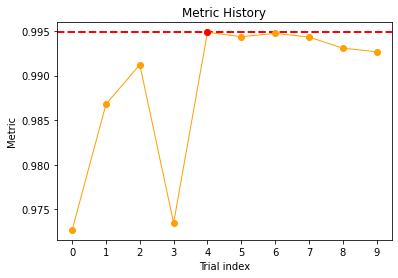

100%|██████████| 10/10 [1:09:15<00:00, 415.58s/trial, best loss: -0.9948552040339631]
HPARAMETER SEARCH FINISHED.


In [8]:
delete_file('trials_sklearn')

model = sklearn_model.SklearnModel1(minimize_metric = False)

res = model.search(data, crf_params.search_space, crf_params.search_fixed, num_iter = 10)
best_hparams = res['best_params']
best_hparams.update(crf_params.search_fixed)

In [9]:
model = sklearn_model.SklearnModel1(minimize_metric = False, **best_hparams)
res = model.fit(data)

res

c:\projects\personal\kaggle\kaggle_coleridge_initiative\mlmodels\sklearn_model.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_train = np.array(y_train).ravel()
c:\projects\personal\kaggle\kaggle_coleridge_initiative\mlmodels\sklearn_model.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_val = np.array(y_val).ravel()


{'metric': 0.9948552040339631}

In [10]:
data['test_data'] = data['val_data']
model.test(data)

0.9948552040339631

In [54]:
test_preds = []
ids = []
for test_id in test_example_names:
    
    # Load and preprocess
    doc = load_train_example_by_name(test_id)
    doc_tokens = preprocess_tokenize_doc(doc)

    # Extract features
    x = {'output': pd.DataFrame({'TOKEN': doc_tokens})}
    x = feature_extractor.transform(x)

    # Predict
    pred = model.predict([x])
    pred = pred[0]['output'][0]
    pred = np.array([int(p) for p in pred])

    # Get corresponding tokens
    pos_pred_idx = [i[0] for i in np.argwhere(pred == 1)]
    pred_tokens = [doc_tokens[i] for i in pos_pred_idx]

    pred_joined = ' '.join(pred_tokens)

    test_preds.append(pred_joined)
    ids.append(test_id)

sub_df = pd.DataFrame(columns = ['Id', 'PredictionString'])
sub_df['Id'] = ids
sub_df['PredictionString'] = test_preds

In [55]:
pd.options.display.max_rows = 100
sub_df

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,the alzheimer s disease neuroimaging initiativ...
1,2f392438-e215-4169-bebf-21ac4ff253e1,the trends in international mathematics and sc...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,noaa storm surge inundation slosh model
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


In [62]:
model.save()